In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from Local modules.
from curve_fit import CurveFitLinear, CurveFitReciprocal
from data_keys import *
from data import load_index_data, load_stock_data, load_usa_cpi
from returns import annualized_returns, prepare_ann_returns

## Load Data

In [4]:
# Define the ticker-names for the stocks we consider.
ticker_SP500 = "S&P 500"
ticker_JNJ = "JNJ"
ticker_K = "K"
ticker_PG = "PG"
ticker_WMT = "WMT"

In [5]:
# Load the financial data for the stocks.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_JNJ = load_stock_data(ticker=ticker_JNJ)
df_K = load_stock_data(ticker=ticker_K)
df_PG = load_stock_data(ticker=ticker_PG)
df_WMT = load_stock_data(ticker=ticker_WMT)

In [6]:
# df_JNJ

In [7]:
# Load the US CPI inflation index.
cpi = load_usa_cpi()

## Plotting Functions

In [8]:
def normalize(x):
    """Normalize x to be between 0.0 and 1.0"""
    y = (x - x.min())
    y /= y.max()
    
    return y

In [9]:
def plot_total_return_sales_book_value(df, ticker):
    """
    Plot the Total Return, Sales Per Share, and
    Book-Value Per Share in one plot.
    The data is normalized to be between 0 and 1.

    :param df: Pandas DataFrame with PSALES and TOTAL_RETURN.
    :param ticker: Name for the stock or index.
    :return: Nothing.
    """

    # Copy the relevant data.
    df2 = df[[SALES_PER_SHARE,
              BOOK_VALUE_PER_SHARE,
              TOTAL_RETURN]].copy()

    # Drop all rows with NA.
    df2.dropna(axis=0, how='any', inplace=True)

    # Normalize the data to be between 0 and 1.
    df2[TOTAL_RETURN] = normalize(df2[TOTAL_RETURN])
    df2[SALES_PER_SHARE] = normalize(df2[SALES_PER_SHARE])
    df2[BOOK_VALUE_PER_SHARE] = normalize(df2[BOOK_VALUE_PER_SHARE])

    # Plot it.
    df2.plot(title=ticker)

In [10]:
def plot_scatter_fit(ax, years, ticker, x, y, x_name):
    """
    Create a scatter-plot with curve-fits.
    
    :param ax: Matplotlib ax-object.
    :param years: Number of years for annualized returns.
    :param ticker: Ticker-name for the stock or index.
    :param x: Data for the x-axis e.g. P/Sales values.
    :param y: Data for the y-axis e.g. annualized returns.
    :return: Nothing.
    """
    # Scatter-plot of the data.
    ax.scatter(x, y)

    # First part of the title.
    title1 = "[{0}] {1}-Year Ann. Return".format(ticker, years)

    # X-values for plotting fitted curves.
    x_min = np.min(x)
    x_max = np.max(x)
    
    # Plot linear curve-fit.
    curve_fit_linear = CurveFitLinear(x=x, y=y)
    x_range = np.array([x_min, x_max])
    y_pred = curve_fit_linear.predict(x=x_range)
    ax.plot(x_range, y_pred, color='black')
    # Title with these curve-fit parameters.
    title2 = "black = {0:.1%} x " + x_name + " + {1:.1%}"
    title2 = title2.format(*curve_fit_linear.params)

    # Plot reciprocal curve-fit.
    curve_fit_reciprocal = CurveFitReciprocal(x=x, y=y)
    x_range = np.arange(x_min, x_max, (x_max/x_min)/1000)
    y_pred = curve_fit_reciprocal.predict(x=x_range)
    ax.plot(x_range, y_pred, color='red')
    # Title with these curve-fit parameters.
    title3 = "red = {0:.1%} / " + x_name + " + {1:.1%}"
    title3 = title3.format(*curve_fit_reciprocal.params)

    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Convert y-ticks to percentages.
    # We use a custom FuncFormatter because PercentFormatter
    # is inconsistent with string-formatters used elsewhere.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

In [11]:
def plot_ann_returns(ticker, df, key=PSALES):
    """
    Create multiple scatter-plots with P/Sales or P/Book
    vs. Annualized Returns for 1-10 years.
    
    :param ticker: Ticker-name for the stock or index.
    :param df: Pandas DataFrame containing PSALES and TOTAL_RETURN.
    :param key: Name of data-column to use, PSALES or PBOOK.
    :return: Nothing.
    """

    # Create 10 sub-plots.
    fig, axes = plt.subplots(5, 2, figsize=(10, 20))
    fig.subplots_adjust(hspace=0.6, wspace=0.15)

    # For each sub-plot make a new scatter-plot.
    for i, ax in enumerate(axes.flat):
        # The number of years for the annualized returns.
        years = i + 1

        # Prepare the data.
        # x is the P/Sales or P/Book and y is the annualized returns.
        x, y = prepare_ann_returns(df=df, years=years, key=key)

        # Scatter-plot with curve-fits etc.
        plot_scatter_fit(ax=ax, years=years, x_name=key,
                         ticker=ticker, x=x, y=y)
        
        # Set the x-label.
        ax.set_xlabel(key)

        # Only set y-label for left-hand plots to save space.
        if i % 2 == 0:
            ax.set_ylabel("Annualized Return")
            
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [12]:
def plot_ann_returns_adjusted(ticker, df, years, subtract, key=PSALES):
    """
    Create a single scatter-plot with P/Sales or P/Book
    vs. Annualized Returns for the given number of years.
    The returns are growth-adjusted with the subtract-series.
    
    This is used for plotting the P/Sales vs. Ann. Returns of
    e.g. the S&P 500 adjusted for the growth in Sales-Per-Share
    or the growth in the Consumer Price Index.
    
    :param ticker: Ticker-name for the stock or index.
    :param df: Pandas DataFrame containing PSALES and TOTAL_RETURN.
    :param key: Name of data-column to use, PSALES or PBOOK.
    :param years: Number of years for annualized returns.
    :param subtract: Pandas Series used for growth-adjustment.
    :return: Nothing.
    """

    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Prepare the data.
    # x is the P/Sales or P/Book.
    # y is the adjusted annualized returns.
    x, y = prepare_ann_returns(df=df, years=years,
                               subtract=subtract, key=key)
    
    # Scatter-plot with curve-fits etc.
    plot_scatter_fit(ax=ax, years=years, x_name=key,
                     ticker=ticker, x=x, y=y)

    # Set the axis-labels.
    ax.set_xlabel(key)
    ax.set_ylabel("Annualized Return (Growth Adjusted)")
   
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [13]:
def plot_total_return(df, ticker, start_date=None):
    """
    Plot the Total Return.

    :param df: Pandas DataFrame with TOTAL_RETURN.
    :param ticker: Ticker-name for the stock or index.
    :param start_date: Start-date for the plot.
    :return: Nothing.
    """

    # Get the data from the given start-date.
    tot_ret = df[TOTAL_RETURN][start_date:].dropna()
    
    # Normalize to start at 1.
    tot_ret /= tot_ret[0]
    
    # Plot it.
    tot_ret.plot(title=ticker + " - Total Return", grid=True)

In [14]:
def plot_psales(df, ticker, start_date=None):
    """
    Plot the P/Sales ratio.

    :param df: Pandas DataFrame with PSALES.
    :param ticker: Ticker-name for the stock or index.
    :param start_date: Start-date for the plot.
    :return: Nothing.
    """

    psales = df[PSALES][start_date:].dropna()
    psales.plot(title=ticker + " - P/Sales", grid=True)

In [15]:
def plot_pbook(df, ticker, start_date=None):
    """
    Plot the P/Book ratio.

    :param df: Pandas DataFrame with PBOOK.
    :param ticker: Ticker-name for the stock or index.
    :param start_date: Start-date for the plot.
    :return: Nothing.
    """

    pbook = df[PBOOK][start_date:].dropna()
    pbook.plot(title=ticker + " - P/Book", grid=True)

In [16]:
def plot_pdividend(df, ticker, start_date=None):
    """
    Plot the P/Dividend ratio.

    :param df: Pandas DataFrame with PDIVIDEND.
    :param ticker: Ticker-name for the stock or index.
    :param start_date: Start-date for the plot.
    :return: Nothing.
    """

    pdividend = df[PDIVIDEND][start_date:].dropna()
    pdividend.plot(title=ticker + " - P/Dividend", grid=True)

## S&P 500
Total Return for the period we consider:

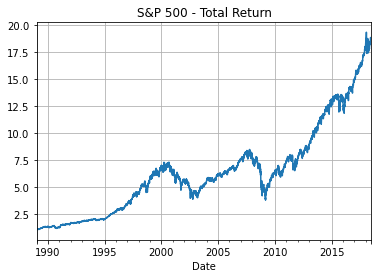

In [17]:
start_date = df_SP500[PSALES].dropna().index[0]
plot_total_return(df=df_SP500, ticker=ticker_SP500,
                  start_date=start_date)

P/Sales ratio for this period:

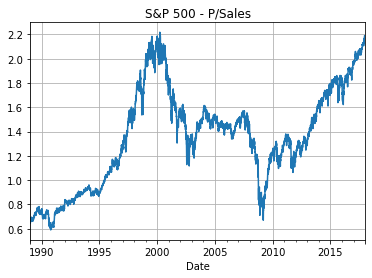

In [18]:
plot_psales(df=df_SP500, ticker=ticker_SP500, start_date=start_date)

P/Book ratio for this period:

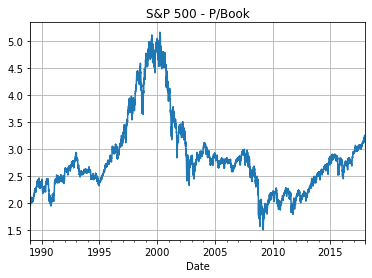

In [19]:
plot_pbook(df=df_SP500, ticker=ticker_SP500, start_date=start_date)

P/Dividend ratio for this period:

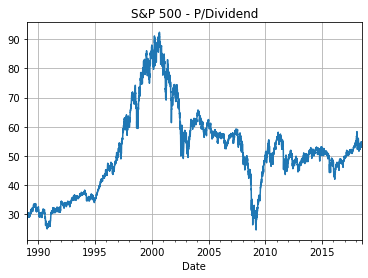

In [20]:
plot_pdividend(df=df_SP500, ticker=ticker_SP500, start_date=start_date)

### S&P 500 - P/Sales vs. Annualized Returns

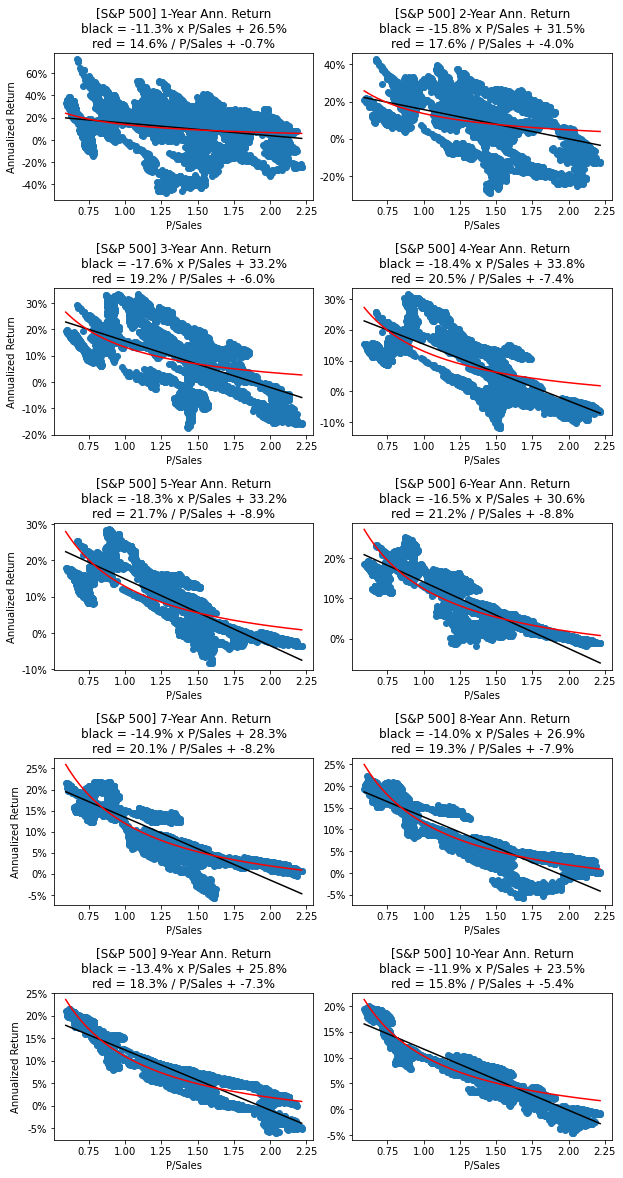

In [21]:
plot_ann_returns(ticker=ticker_SP500, df=df_SP500, key=PSALES)

### S&P 500 - P/Book vs. Annualized Returns

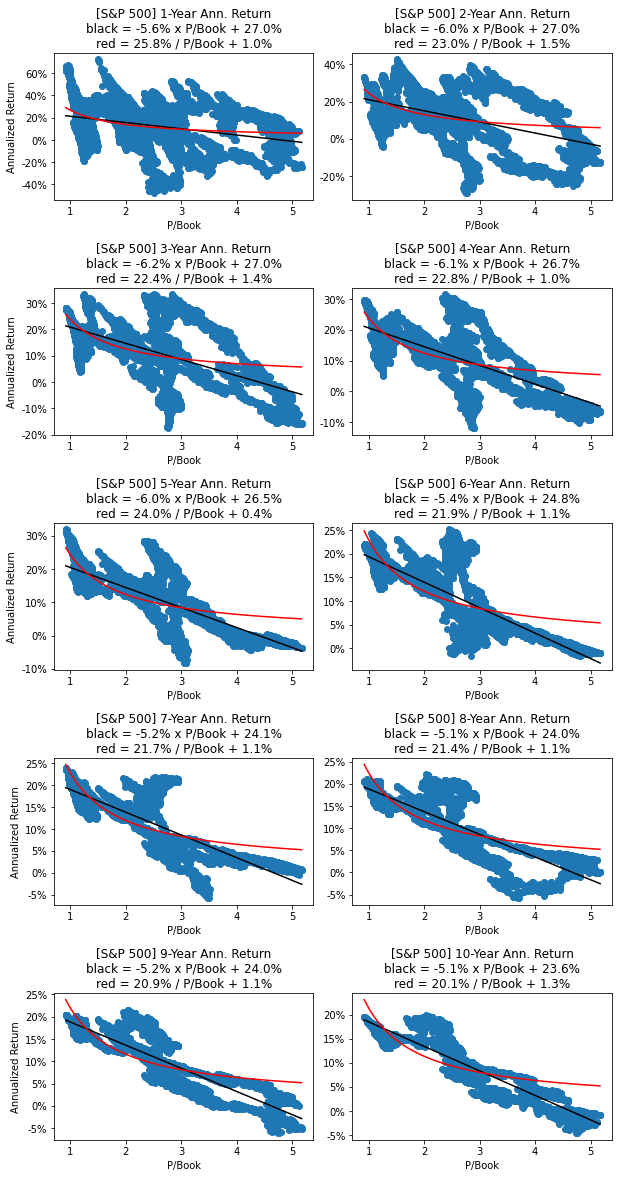

In [22]:
plot_ann_returns(ticker=ticker_SP500, df=df_SP500, key=PBOOK)

### S&P 500 - P/Dividend vs. Annualized Returns

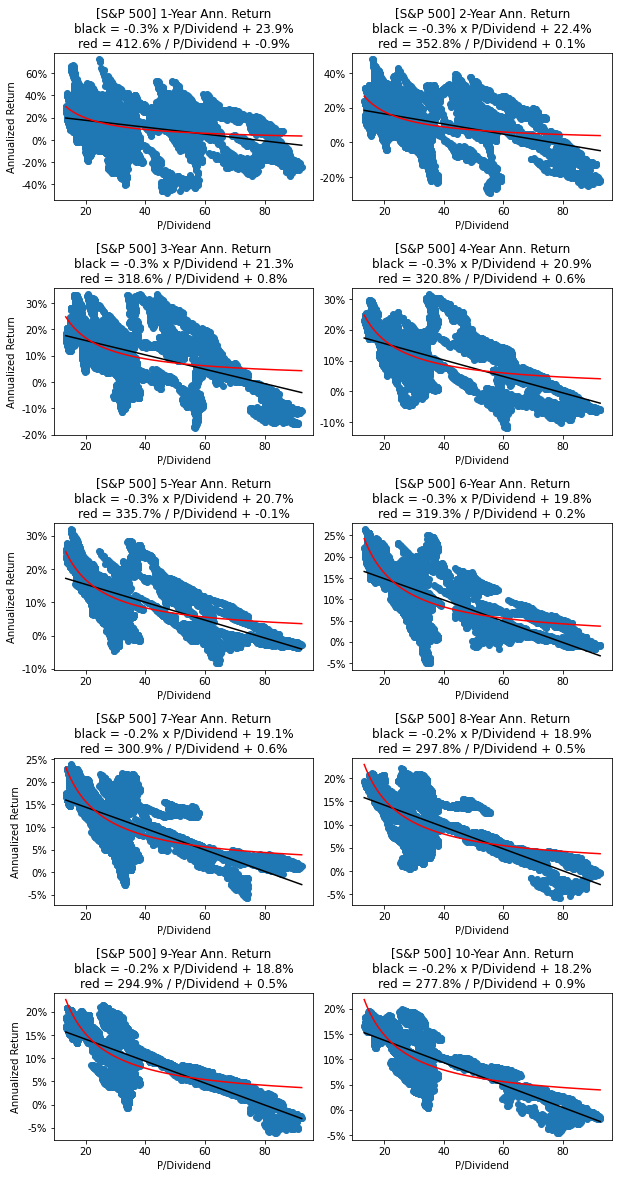

In [23]:
plot_ann_returns(ticker=ticker_SP500, df=df_SP500, key=PDIVIDEND)

### S&P 500 - Adjusting for Inflation

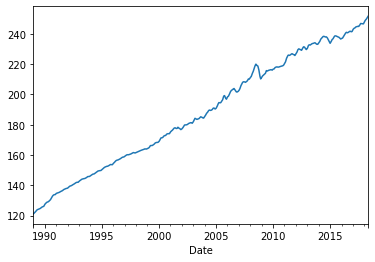

In [24]:
start_date = df_SP500[SALES_PER_SHARE].dropna().index[0]
cpi[start_date:].plot()

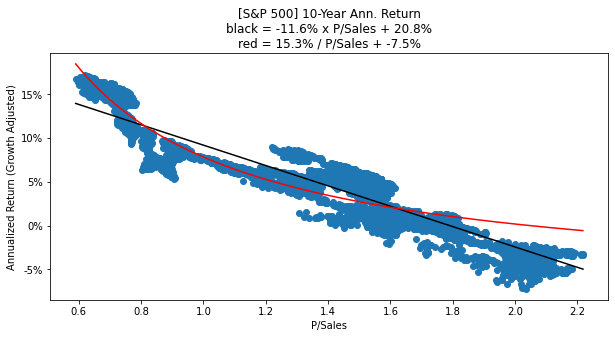

In [25]:
plot_ann_returns_adjusted(df=df_SP500, years=10,
                          ticker=ticker_SP500, subtract=cpi)

## Case Study: Johnson & Johnson (JNJ)

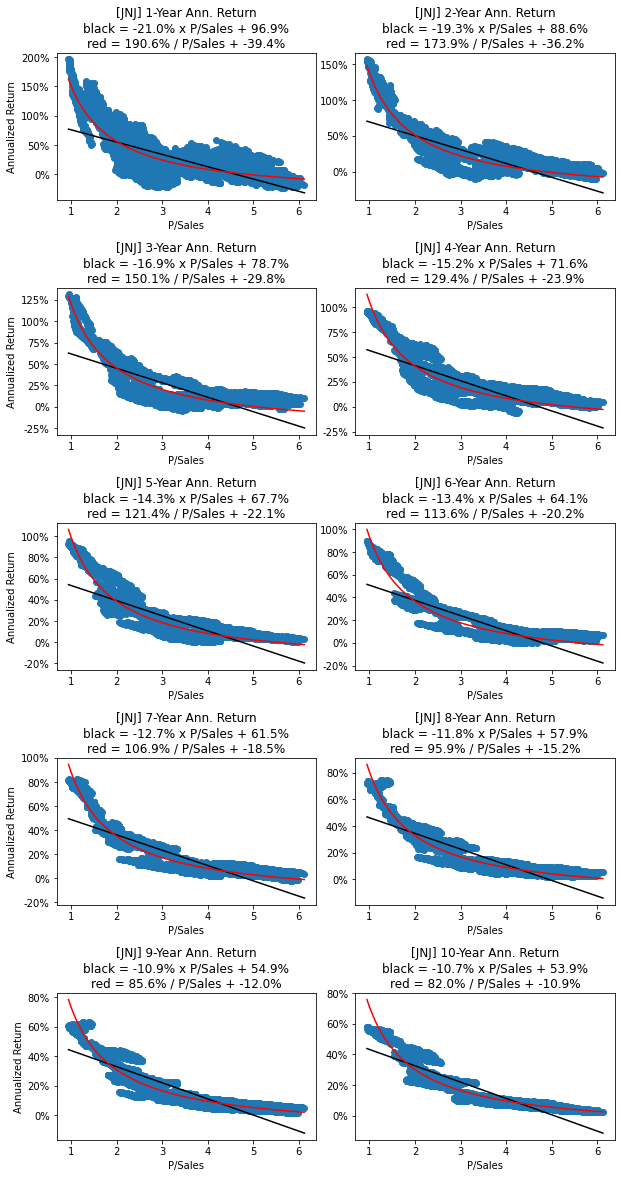

In [26]:
plot_ann_returns(ticker=ticker_JNJ, df=df_JNJ, key=PSALES)

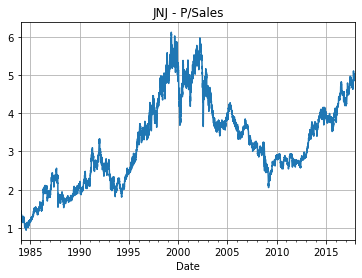

In [27]:
plot_psales(df=df_JNJ, ticker=ticker_JNJ)

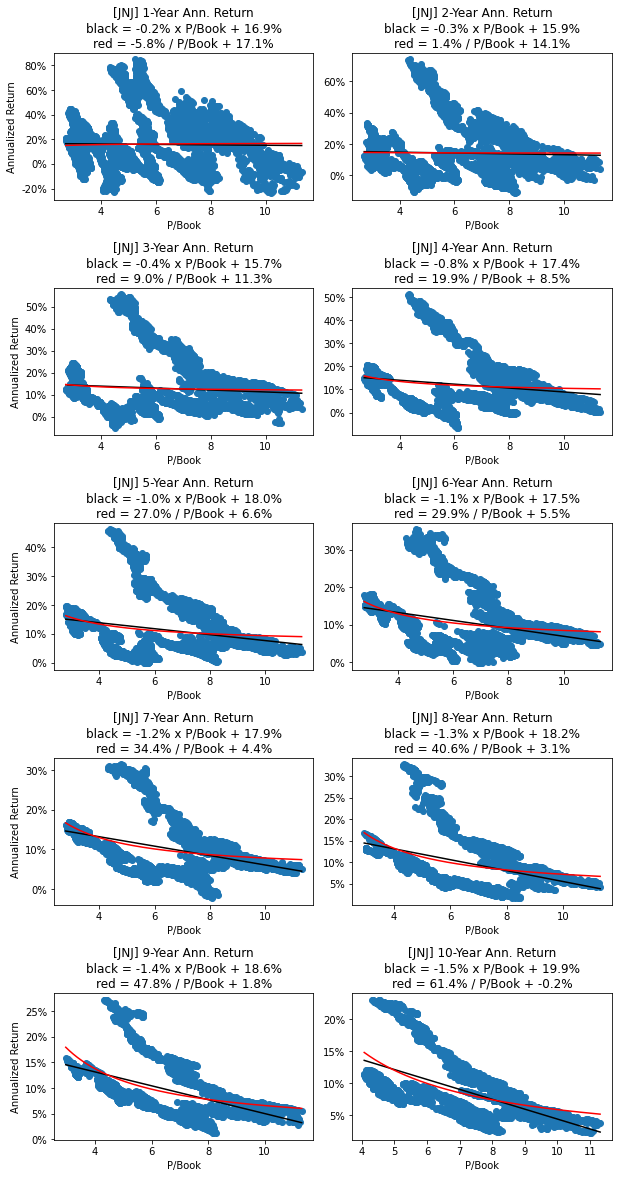

In [28]:
plot_ann_returns(ticker=ticker_JNJ, df=df_JNJ, key=PBOOK)

## Case Study: Procter & Gamble (PG)

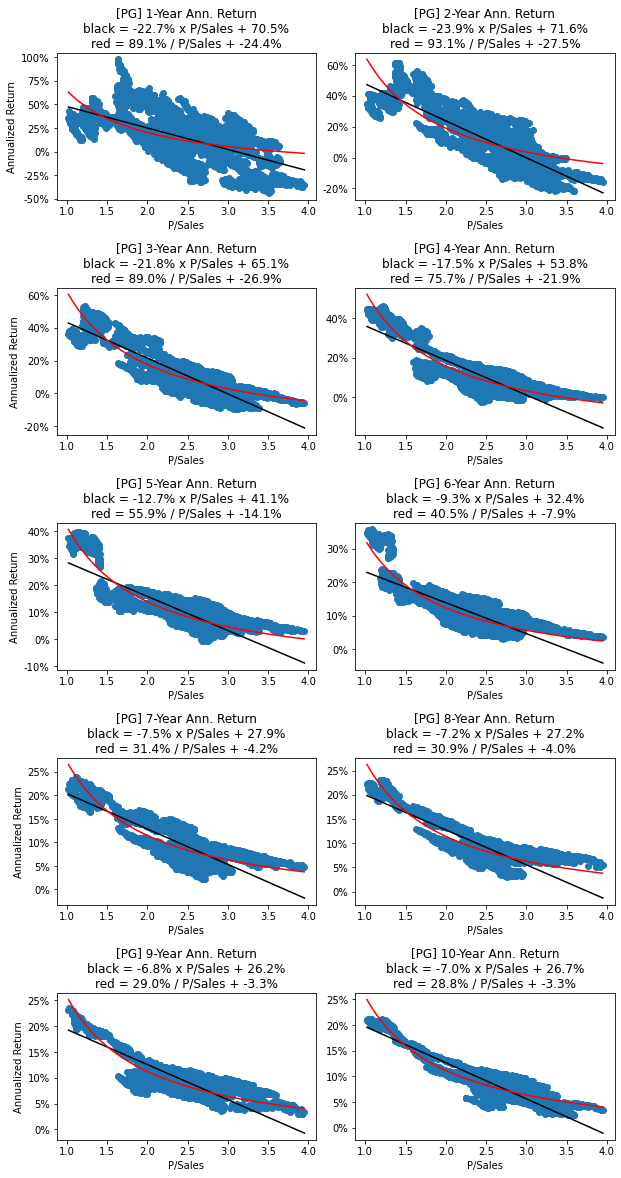

In [29]:
plot_ann_returns(ticker=ticker_PG, df=df_PG, key=PSALES)

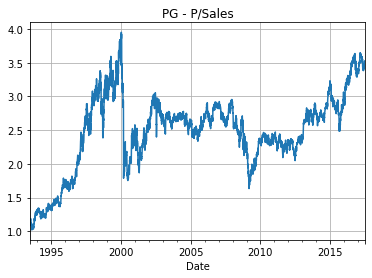

In [30]:
plot_psales(df=df_PG, ticker=ticker_PG)

## Case Study: Kellogg's (K)

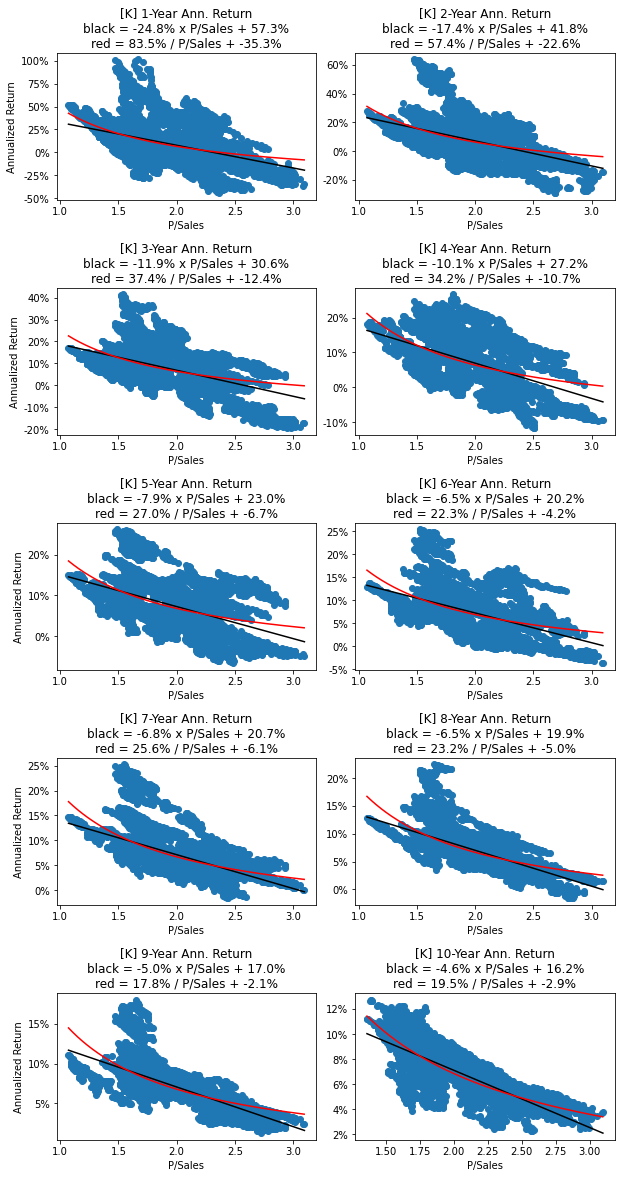

In [31]:
plot_ann_returns(ticker=ticker_K, df=df_K, key=PSALES)

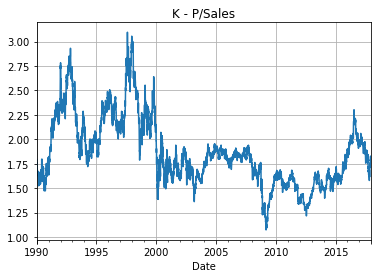

In [32]:
plot_psales(df=df_K, ticker=ticker_K)

## Case Study: Wal-Mart (WMT)

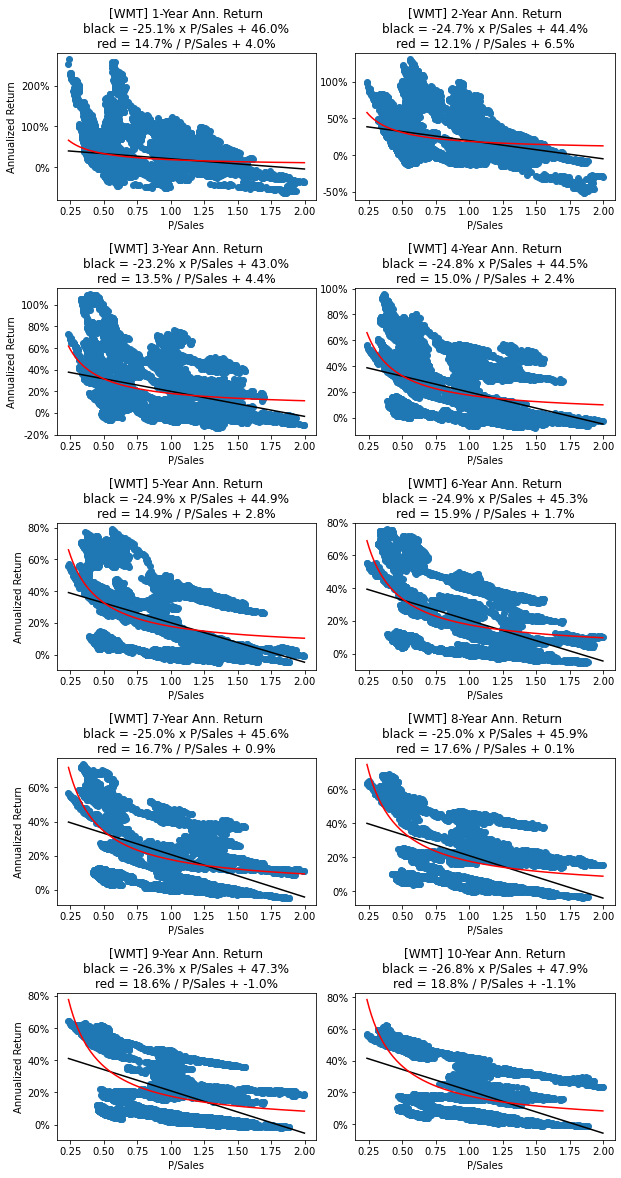

In [33]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, key=PSALES)

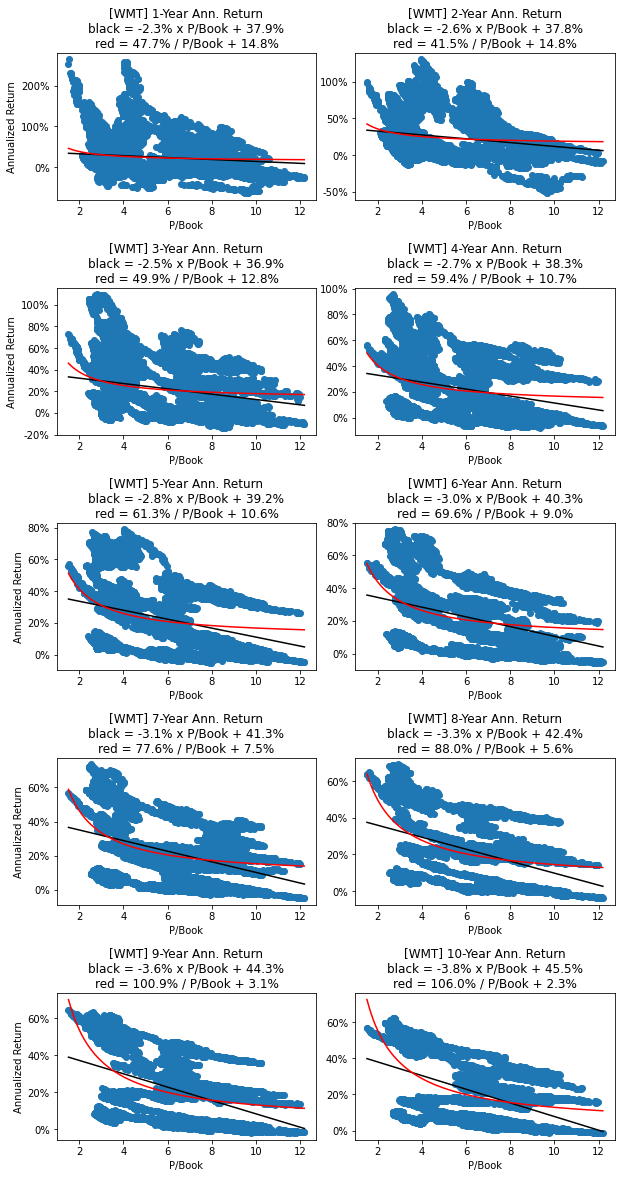

In [34]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, key=PBOOK)

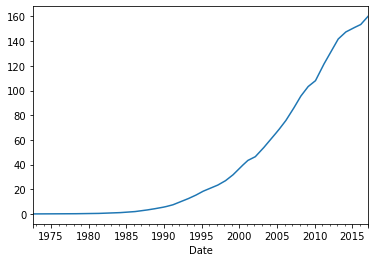

In [35]:
df_WMT[SALES_PER_SHARE].dropna().plot()

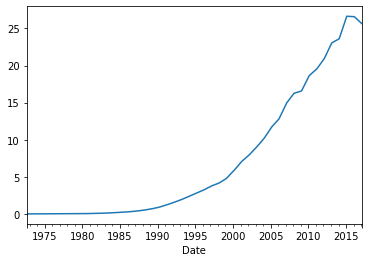

In [36]:
df_WMT[BOOK_VALUE_PER_SHARE].dropna().plot()